# Extract, Load, Filter

In [36]:
# Import necessary libraries
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

# Set Seaborn's aesthetic parameters to match Matplotlib's
sns.set()

# Constants
ZIP_PATH = 'fr.openfoodfacts.org.products.csv.zip'  # Path to the zip file
CSV_PATH = 'fr.openfoodfacts.org.products.csv'  # Path to the csv file you want to extract
UNZIP = False  # flag for unzipping file, set True if you want to unzip file

# Function to unzip the file
def unzip_file(zip_path, csv_path):
    """
    Function to unzip the specified file.
    :param zip_path: Path to the zip file
    :param csv_path: Path to the CSV file you want to extract
    """
    with zipfile.ZipFile(zip_path, 'r') as zfile:
        zfile.extract(csv_path)

# If UNZIP flag is True, then unzip the file
if UNZIP:
    unzip_file(ZIP_PATH, CSV_PATH)

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(CSV_PATH, delimiter="\t", low_memory=False)

# Make a copy of original DataFrame's columns for future reference if needed
original_columns = df.columns.tolist()

# Print the shape of the DataFrame for a quick inspection
print(f"Data shape: {df.shape}")


Data shape: (320772, 162)


In [37]:
# Define constants
MISSING_VALUE_THRESHOLD = 0.5  # Threshold for the proportion of missing values

# Function to drop missing and duplicate values
def clean_data(df):
    """
    Function to drop all columns with 100% missing values and duplicate rows.
    :param df: Input pandas DataFrame
    """
    # Drop columns with 100% missing values
    df.dropna(how="all", axis="columns", inplace=True)
    
    # Drop duplicate rows
    df.drop_duplicates(inplace=True)

# Function to remove columns with missing value proportion more than a threshold
def remove_missing_values(df, threshold):
    """
    Function to remove columns with missing value proportion more than a threshold.
    :param df: Input pandas DataFrame
    :param threshold: Threshold for the proportion of missing values
    :return: DataFrame summary of kept and removed columns
    """
    # Initialize lists to hold kept and removed columns
    columns_kept = []
    columns_removed = []

    # Iterate over each column in the DataFrame
    for col in df.columns.to_list():
        # Compute the proportion of missing values in the column
        missing_values_proportion = df[col].isnull().sum() / len(df[col])
        
        # If proportion of missing values is greater than the threshold, drop the column and add to removed list
        if missing_values_proportion > threshold:
            df.drop(col, axis="columns", inplace=True)
            columns_removed.append(col)
        else:
            # If proportion of missing values is less than or equal to the threshold, add to kept list
            columns_kept.append(col)

    # Create a DataFrame summary of kept and removed columns
    col_summary_df = pd.DataFrame(list(zip(columns_kept, columns_removed)), columns = ['Kept Columns', 'Removed Columns'])
    
    return col_summary_df, columns_removed

# Call the function to clean data
clean_data(df)

# Call the function to remove columns with missing value proportion more than a threshold and get the summary DataFrame
col_summary_df, columns_removed = remove_missing_values(df, MISSING_VALUE_THRESHOLD)

# Print the shape of the cleaned DataFrame
print(f"Data shape: {df.shape}")

# Display the summary DataFrame
col_summary_df


Data shape: (320772, 34)


Kept Columns  \
0                                      code   
1                                       url   
2                                   creator   
3                                 created_t   
4                          created_datetime   
5                           last_modified_t   
6                    last_modified_datetime   
7                              product_name   
8                                    brands   
9                               brands_tags   
10                                countries   
11                           countries_tags   
12                             countries_fr   
13                         ingredients_text   
14                             serving_size   
15                              additives_n   
16                                additives   
17              ingredients_from_palm_oil_n   
18  ingredients_that_may_be_from_palm_oil_n   
19                       nutrition_grade_fr   
20                                   states   
21                              states_tags   
22                                states_fr   
23                              energy_100g   
24                                 fat_100g   
25                       saturated-fat_100g   
26                       carbohydrates_100g   
27                              sugars_100g   
28                               fiber_100g   
29                            proteins_100g   
30                                salt_100g   
31                              sodium_100g   
32                  nutrition-score-fr_100g   
33                  nutrition-score-uk_100g   

                               Removed Columns  
0                                 generic_name  
1                                     quantity  
2                                    packaging  
3                               packaging_tags  
4                                   categories  
5                              categories_tags  
6                                categories_fr  
7                                      origins  
8                                 origins_tags  
9                         manufacturing_places  
10                   manufacturing_places_tags  
11                                      labels  
12                                 labels_tags  
13                                   labels_fr  
14                                   emb_codes  
15                              emb_codes_tags  
16                    first_packaging_code_geo  
17                                      cities  
18                                 cities_tags  
19                             purchase_places  
20                                      stores  
21                                   allergens  
22                                allergens_fr  
23                                      traces  
24                                 traces_tags  
25                                   traces_fr  
26                              additives_tags  
27                                additives_fr  
28              ingredients_from_palm_oil_tags  
29  ingredients_that_may_be_from_palm_oil_tags  
30                               pnns_groups_1  
31                               pnns_groups_2  
32                               main_category  
33                            main_category_fr

## Manually Remove Columns

In [38]:
# List of unnecessary columns
unnecessary_columns = ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 
                       'last_modified_datetime', 'brands_tags', 'countries_tags', 'countries_fr', 
                       'additives', 'states_tags', 'states_fr', 'serving_size', 'ingredients_text',
                       'states']

# Drop unnecessary columns from DataFrame
df.drop(unnecessary_columns, axis=1, inplace=True)

new_column_names = ['Product', 'Brand', 'Country', 'No. Additives', 'No. Palm Oil Ingredients', 'No. Potential Palm Oil Ingredients', 'Nutrition Grade FR', 'Energy 100g', 'Fat 100g', 'Saturated Fat 100g', 'Carbohydrate 100g', 'Sugar 100g', 'Fiber 100g', 'Proteins 100g', 'Salt 100g', 'Sodium 100g', 'Nutri-Score FR 100g', 'Nutri-Score UK 100g']

df.columns = new_column_names

df.head()

Product            Brand Country  No. Additives  \
0              Farine de blé noir  Ferme t'y R'nao   en:FR            NaN   
1  Banana Chips Sweetened (Whole)              NaN      US            0.0   
2                         Peanuts   Torn & Glasser      US            0.0   
3          Organic Salted Nut Mix        Grizzlies      US            0.0   
4                 Organic Polenta   Bob's Red Mill      US            0.0   

   No. Palm Oil Ingredients  No. Potential Palm Oil Ingredients  \
0                       NaN                                 NaN   
1                       0.0                                 0.0   
2                       0.0                                 0.0   
3                       0.0                                 0.0   
4                       0.0                                 0.0   

  Nutrition Grade FR  Energy 100g  Fat 100g  Saturated Fat 100g  \
0                NaN          NaN       NaN                 NaN   
1                  d       2243.0     28.57               28.57   
2                  b       1941.0     17.86                0.00   
3                  d       2540.0     57.14                5.36   
4                NaN       1552.0      1.43                 NaN   

   Carbohydrate 100g  Sugar 100g  Fiber 100g  Proteins 100g  Salt 100g  \
0                NaN         NaN         NaN            NaN        NaN   
1              64.29       14.29         3.6           3.57    0.00000   
2              60.71       17.86         7.1          17.86    0.63500   
3              17.86        3.57         7.1          17.86    1.22428   
4              77.14         NaN         5.7           8.57        NaN   

   Sodium 100g  Nutri-Score FR 100g  Nutri-Score UK 100g  
0          NaN                  NaN                  NaN  
1        0.000                 14.0                 14.0  
2        0.250                  0.0                  0.0  
3        0.482                 12.0                 12.0  
4          NaN                  NaN                  NaN

# Impute Missing Values & Replace Extreme Values

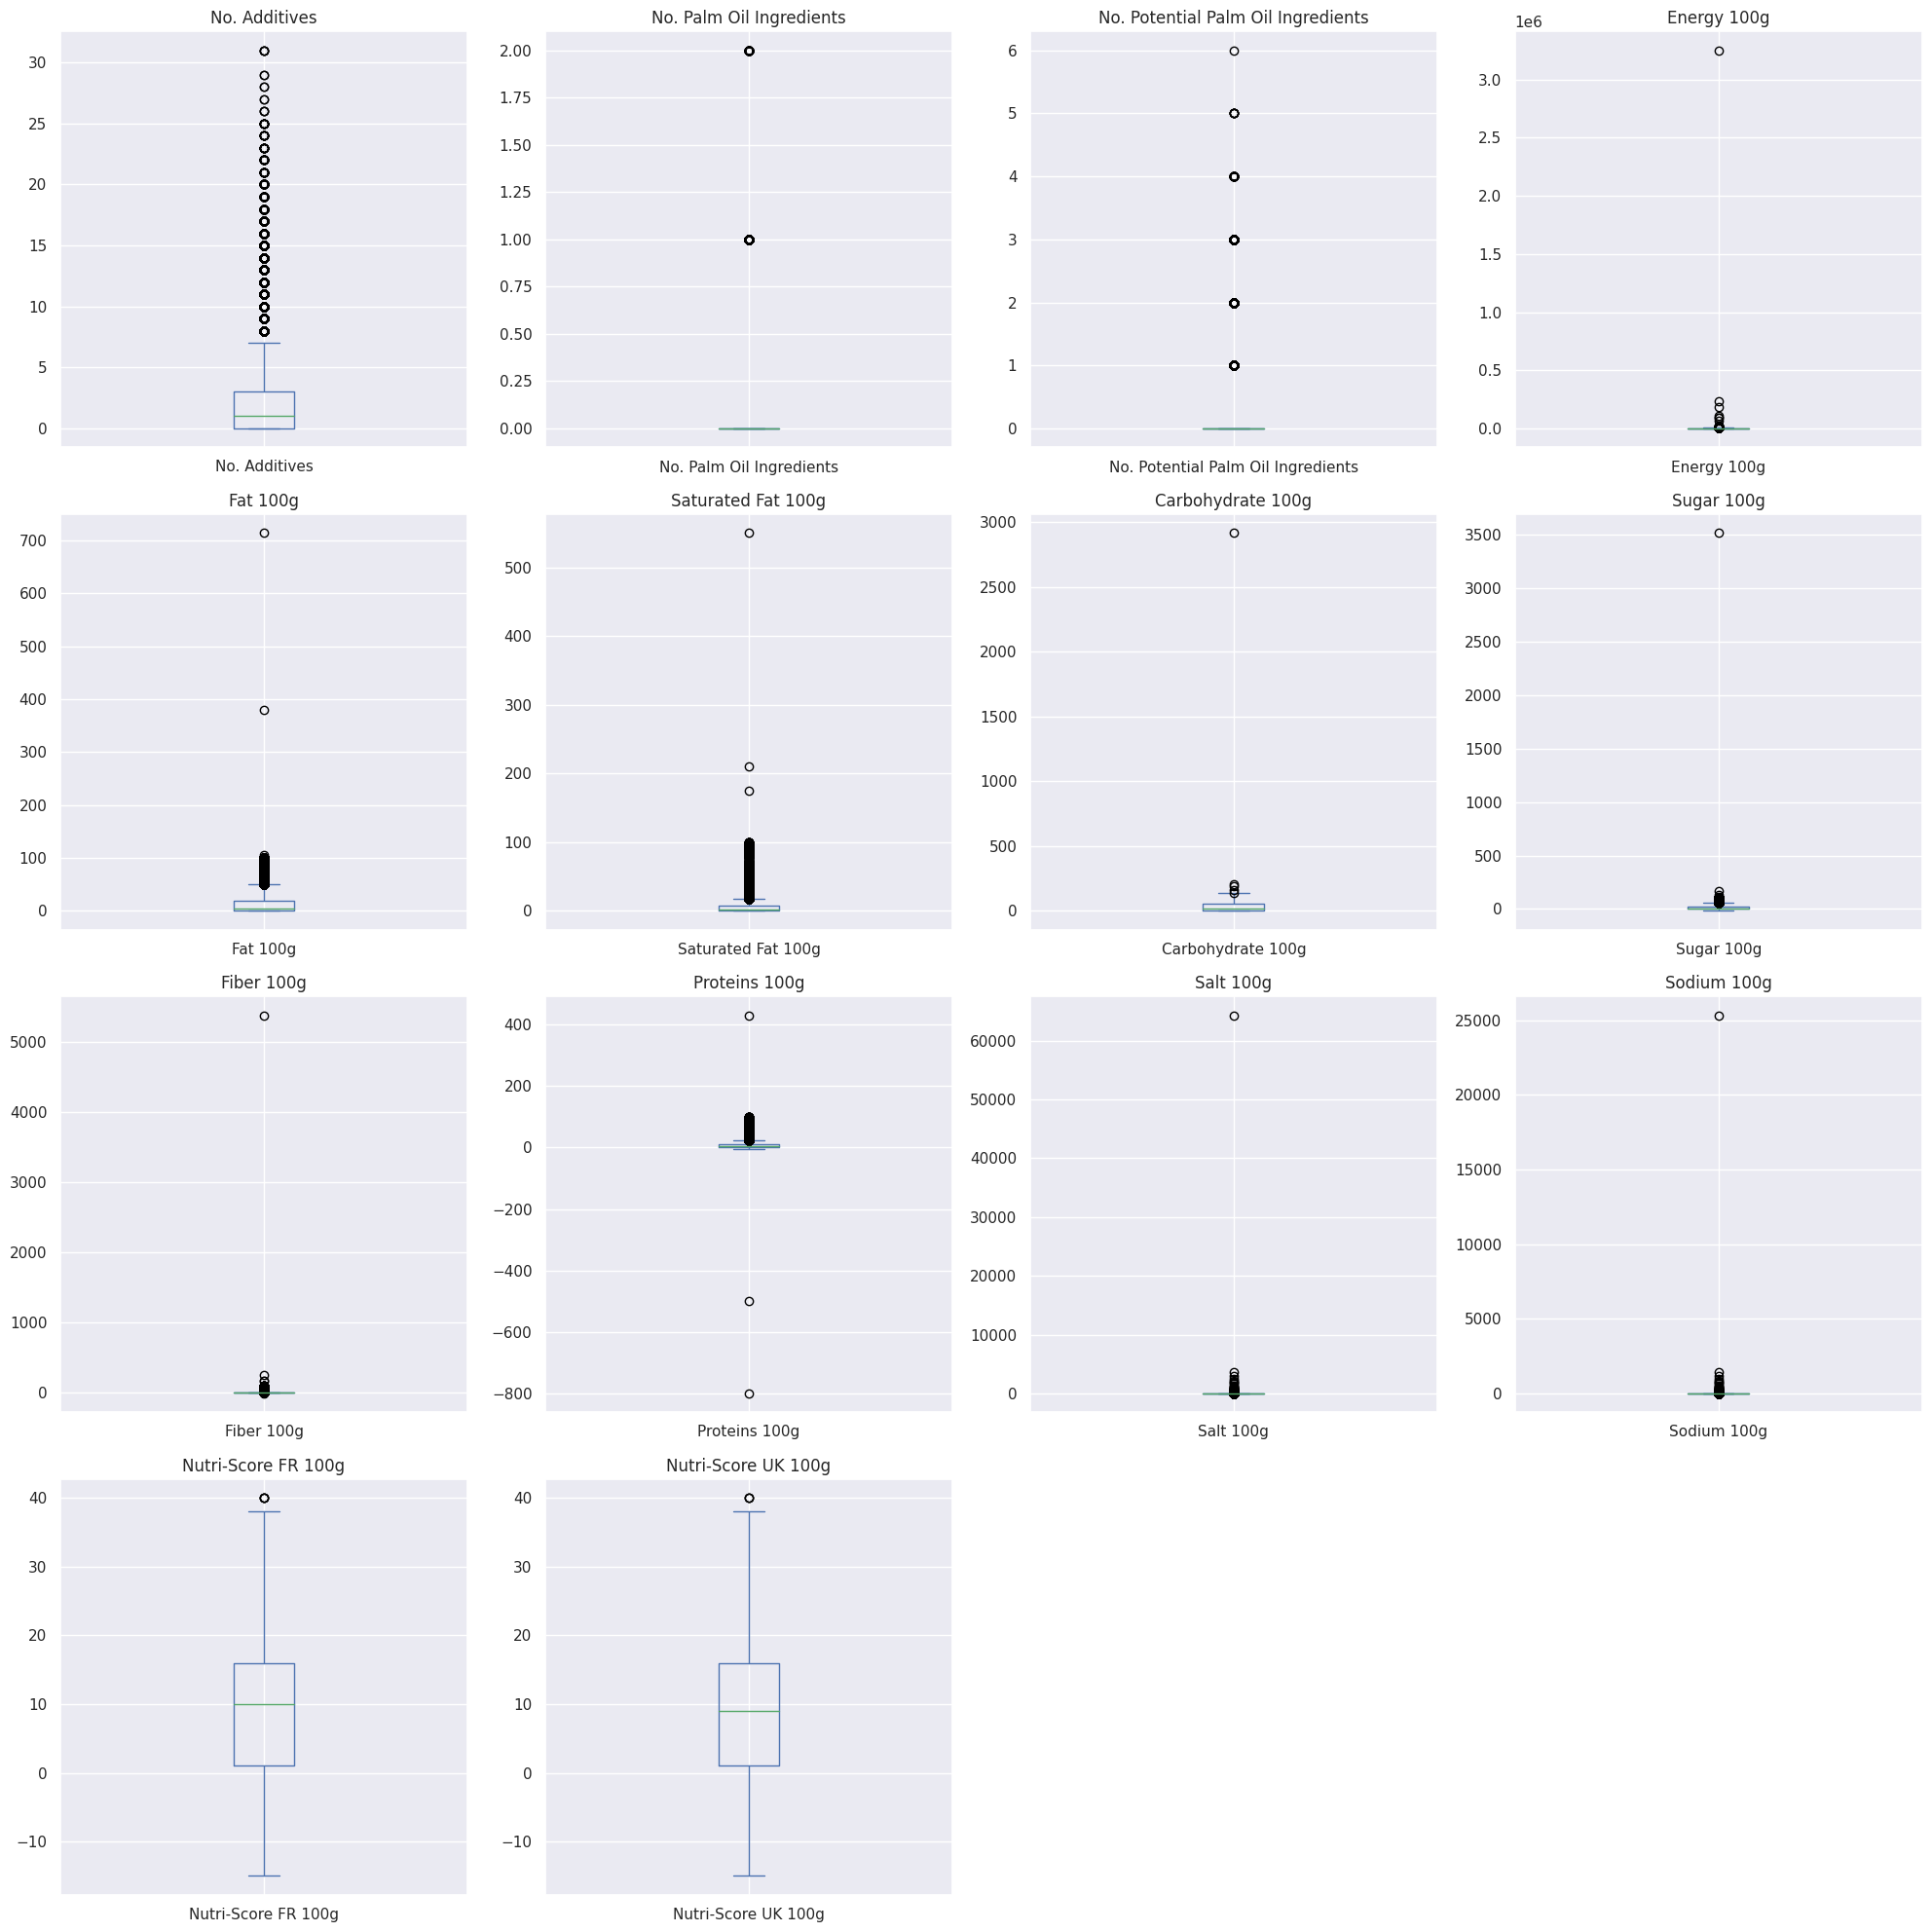

In [39]:
def plot_boxplots(df):
    """
    Function to plot boxplots of all numeric columns in a DataFrame.
    :param df: Input pandas DataFrame
    """

    # Select only numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Calculate number of rows needed for subplots based on the number of numeric columns
    # We're creating a grid of subplots with 4 columns, so we need n/4 rows, rounded up
    n = len(numeric_cols)
    n_rows = (n + 3) // 4  # This is a common trick to round up integer division

    # Create the subplots
    fig, axes = plt.subplots(n_rows, 4, figsize=(20, n_rows * 5))

    # Iterate over each axis and each numeric column together
    for ax, col in zip(axes.flatten(), numeric_cols):
        # Plot a boxplot of the current column on the current axis
        df[col].plot(kind='box', ax=ax)
        # Set the title of the current axis to the column name
        ax.set_title(col)

    # If the number of numeric columns is not a multiple of 4, some subplots will be empty
    # These should be removed to clean up the display
    if n % 4:
        # Remove the empty subplots by deleting the axes
        for i in range(n, n_rows * 4):
            fig.delaxes(axes.flatten()[i])

    # Adjust the layout so everything fits nicely
    plt.tight_layout()

    # Display the plot
    plt.show()

# Call the function to plot boxplots
plot_boxplots(df)

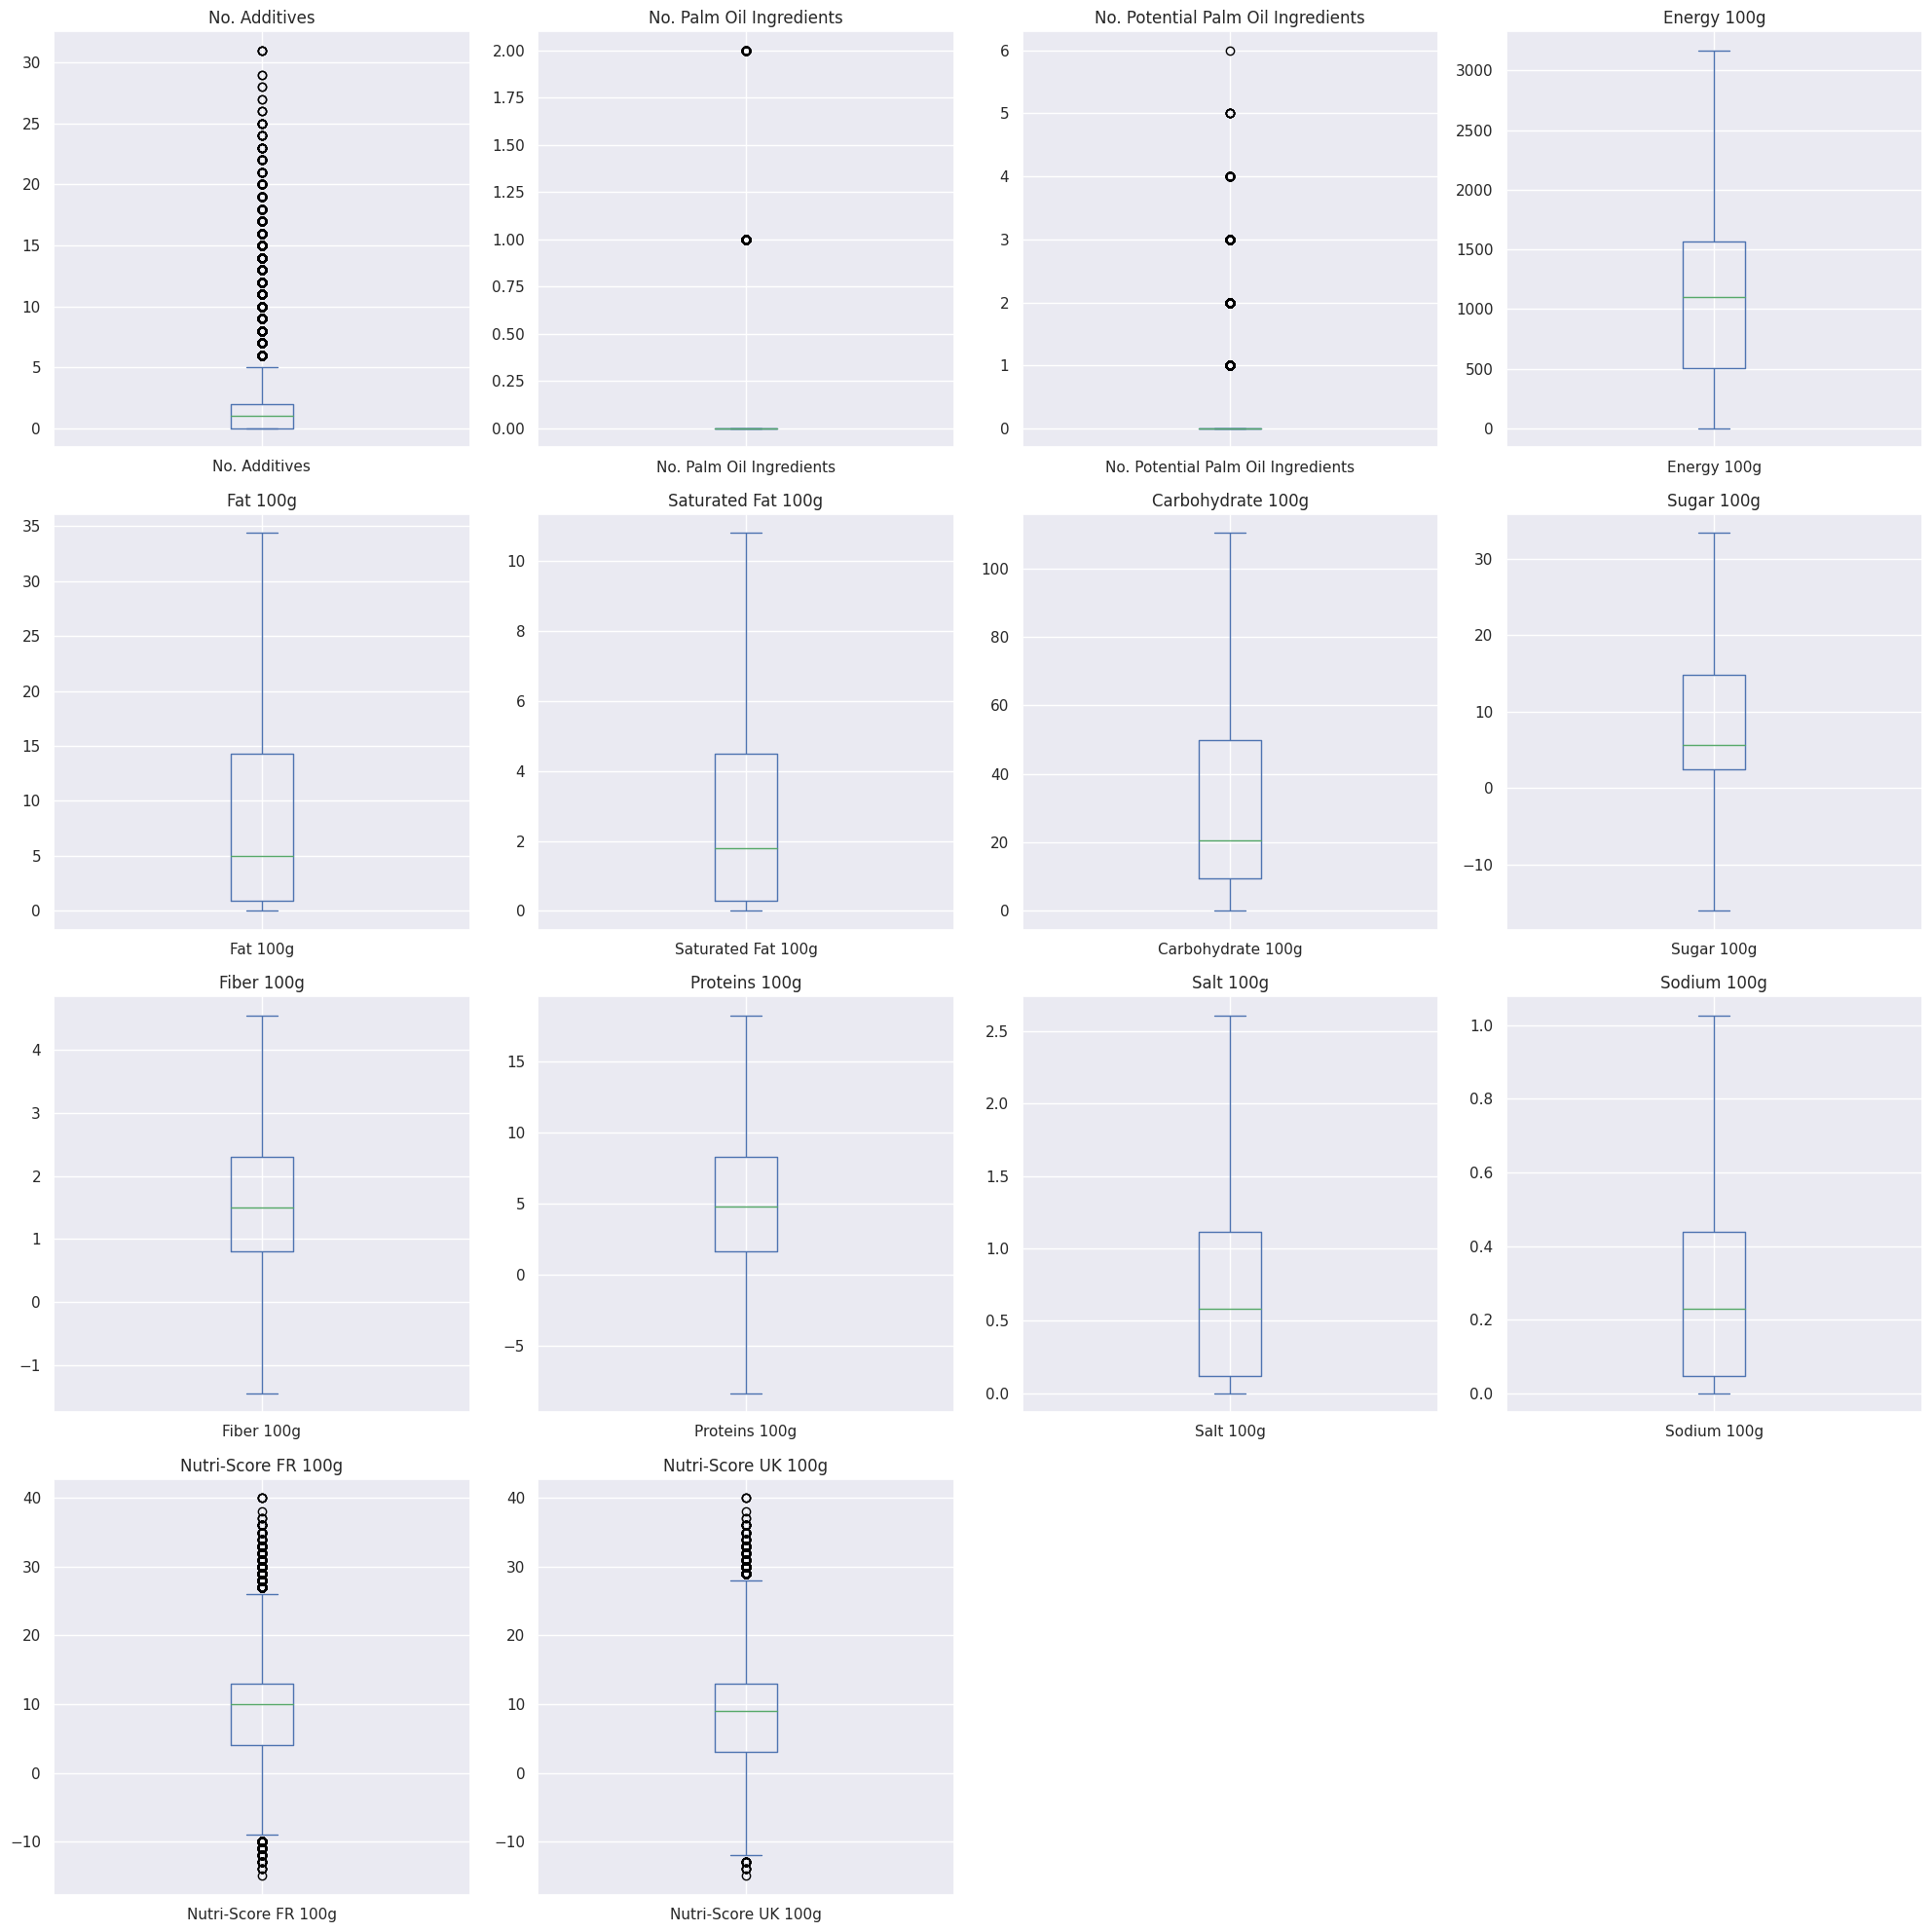

In [40]:
# Define relevant variables
variables = df.columns.to_list()
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Columns to ignore during outlier treatment
ignore_cols = ['Nutri-Score FR 100g', 
               'Nutri-Score UK 100g', 
               'No. Additives', 
               'No. Palm Oil Ingredients', 
               'No. Potential Palm Oil Ingredients']

# Create an imputer object for numeric columns, median strategy is chosen to minimize the impact of outliers
numeric_imputer = SimpleImputer(strategy='median')

# Create an imputer object for categorical columns, most_frequent strategy is chosen for simplicity
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Define thresholds for missing values and quantiles
missing_value_threshold = 0.5
upper_limit = 0.75
lower_limit = 0.25
factor = 1.5  # Factor for outlier detection

# Iterate over each column in the dataframe
for column in variables:
    missing_values_count = df[column].isnull().sum()
    total_values = len(df[column])
    
    # If less than half the values are missing, impute the missing values
    if missing_values_count / total_values <= missing_value_threshold:
        # If column is numeric
        if column in numeric_cols:
            # Impute with median for numeric columns
            df[column] = numeric_imputer.fit_transform(df[column].values.reshape(-1, 1))

            # If column is a floating point column and not in the ignore list, clip outliers
            if (column not in ignore_cols):
                # Calculate IQR
                Q1 = df[column].quantile(lower_limit)
                Q3 = df[column].quantile(upper_limit)
                IQR = Q3 - Q1
                
                # Calculate upper and lower fences for outlier detection
                lower_fence = Q1 - (factor*IQR)
                upper_fence = Q3 + (factor*IQR)
                
                # Clip (limit) values to upper and lower fences
                df[column] = df[column].clip(lower=lower_fence, upper=upper_fence)

        else:
            # Impute with mode (most frequent) for categorical columns
            df[column] = categorical_imputer.fit_transform(df[column].values.reshape(-1, 1))

    else:
        # If more than half the values are missing, drop the column
        df.drop(column, axis="columns", inplace=True)

# Call the function to plot boxplots
plot_boxplots(df)

# Univariate Analaysis

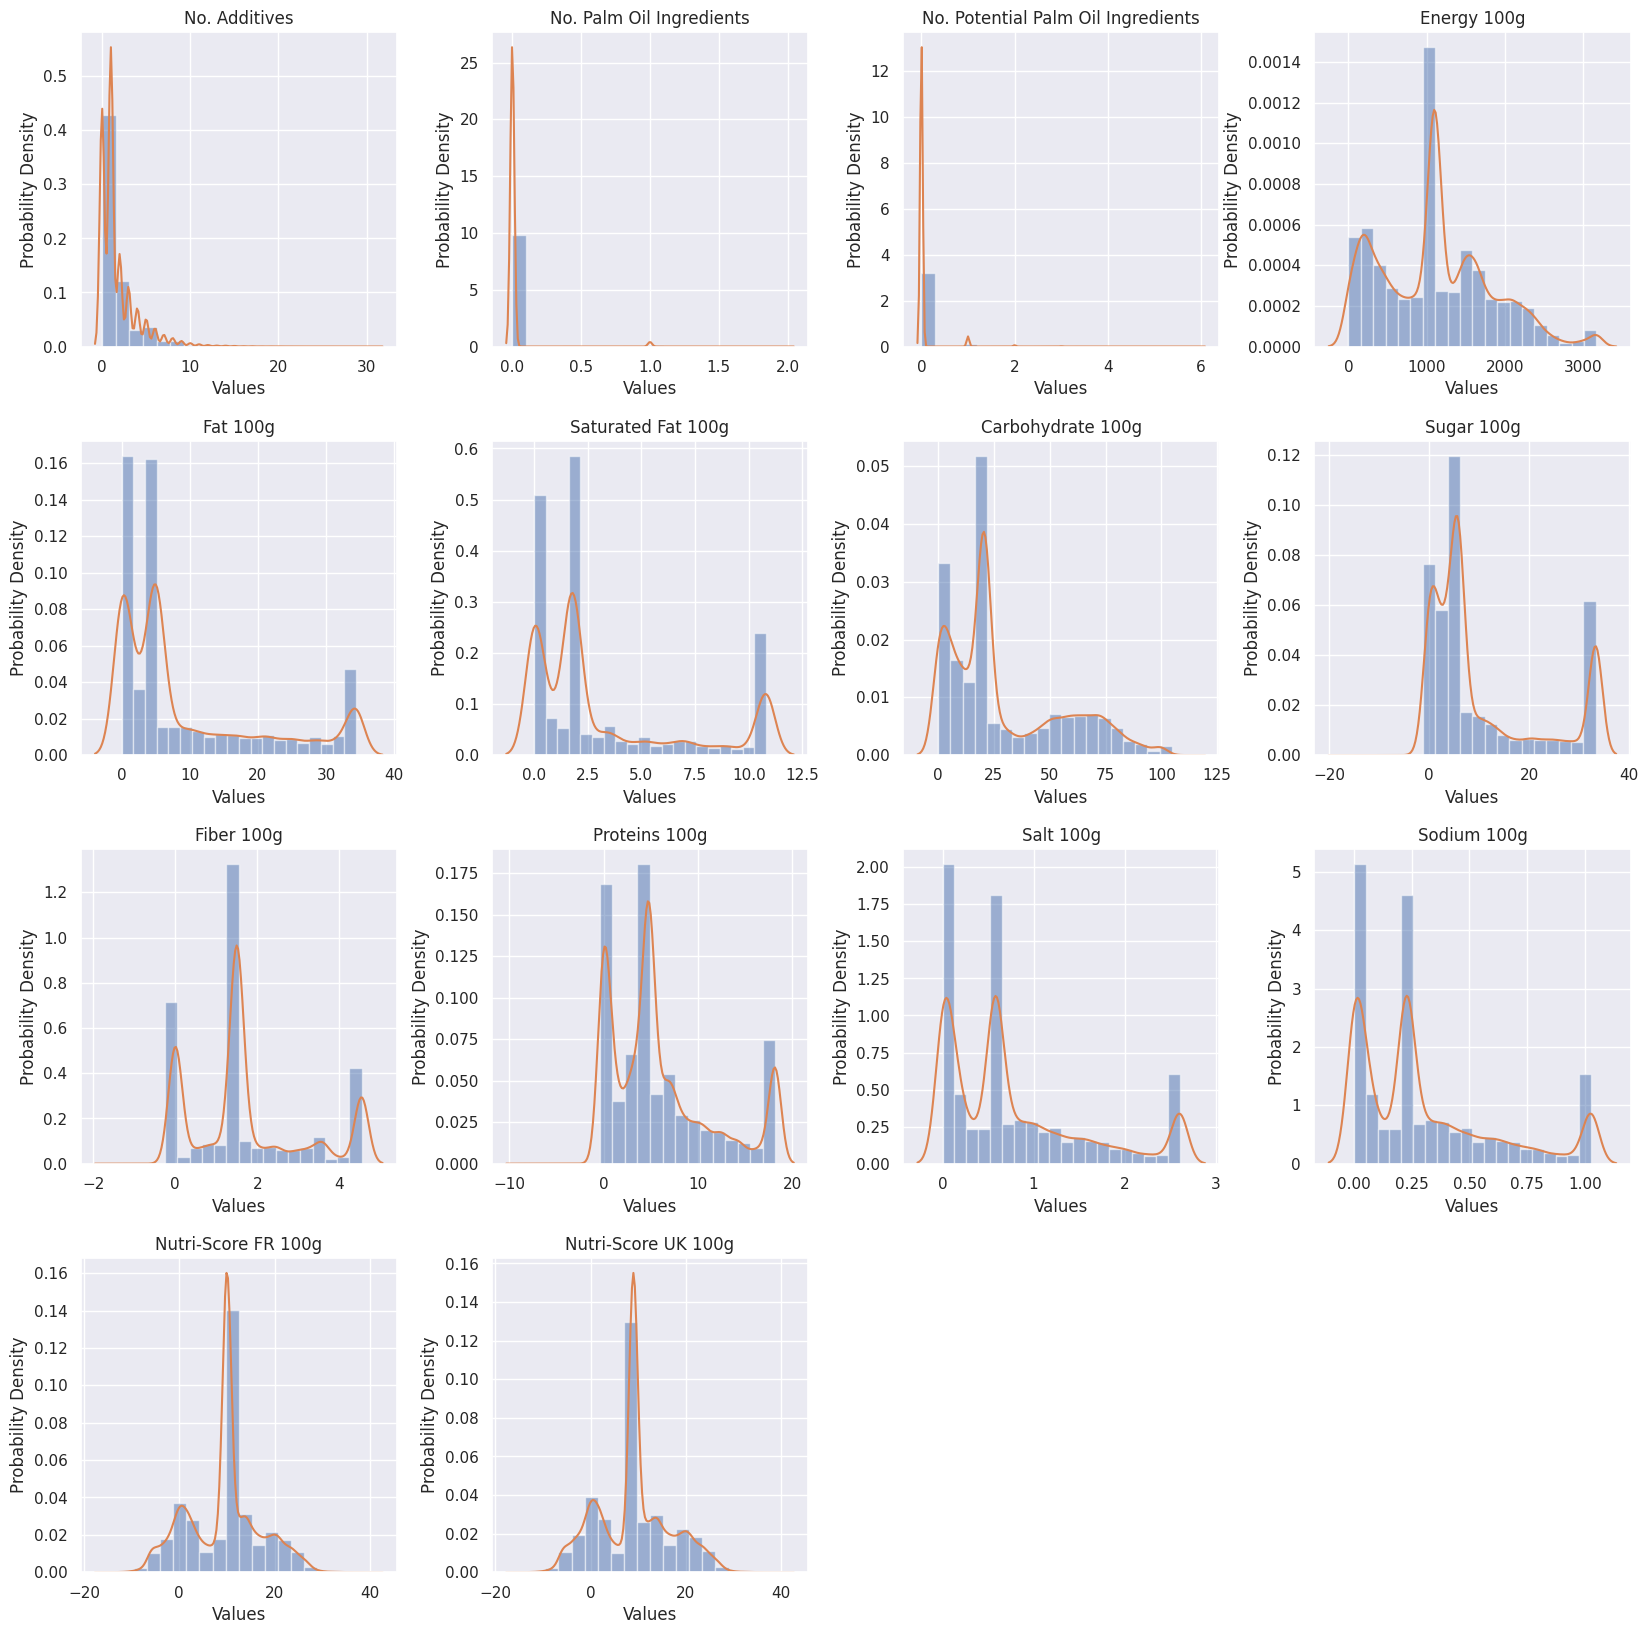

In [41]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Plotting the histogram
axes = df.hist(figsize=(20,20), bins=20, density=True, alpha=0.5)

# Loop through axes and numeric columns to add KDE plot
for ax, col in zip(axes.flatten(), numeric_cols):
    sns.kdeplot(df[col], bw_adjust=1.5, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Values')
    ax.set_ylabel('Probability Density')

# Show the plot
plt.show()

In [43]:
df.select_dtypes(include='object')

Product            Brand  \
0                                      Farine de blé noir  Ferme t'y R'nao   
1                          Banana Chips Sweetened (Whole)        Carrefour   
2                                                 Peanuts   Torn & Glasser   
3                                  Organic Salted Nut Mix        Grizzlies   
4                                         Organic Polenta   Bob's Red Mill   
...                                                   ...              ...   
320767                                  Tomato & ricotta          Panzani    
320768  Mint Melange Tea A Blend Of Peppermint, Lemon ...     Trader Joe's   
320769                                            乐吧泡菜味薯片               乐吧   
320770                           Tomates aux Vermicelles             Knorr   
320771                    Sugar Free Drink Mix, Peach Tea    Market Pantry   

       Country Nutrition Grade FR  
0        en:FR                  d  
1           US                  d  
2           US                  b  
3           US                  d  
4           US                  d  
...        ...                ...  
320767   en:RO                  d  
320768      US                  b  
320769   China                  d  
320770   en:FR                  d  
320771      US                  d  

[320772 rows x 4 columns]

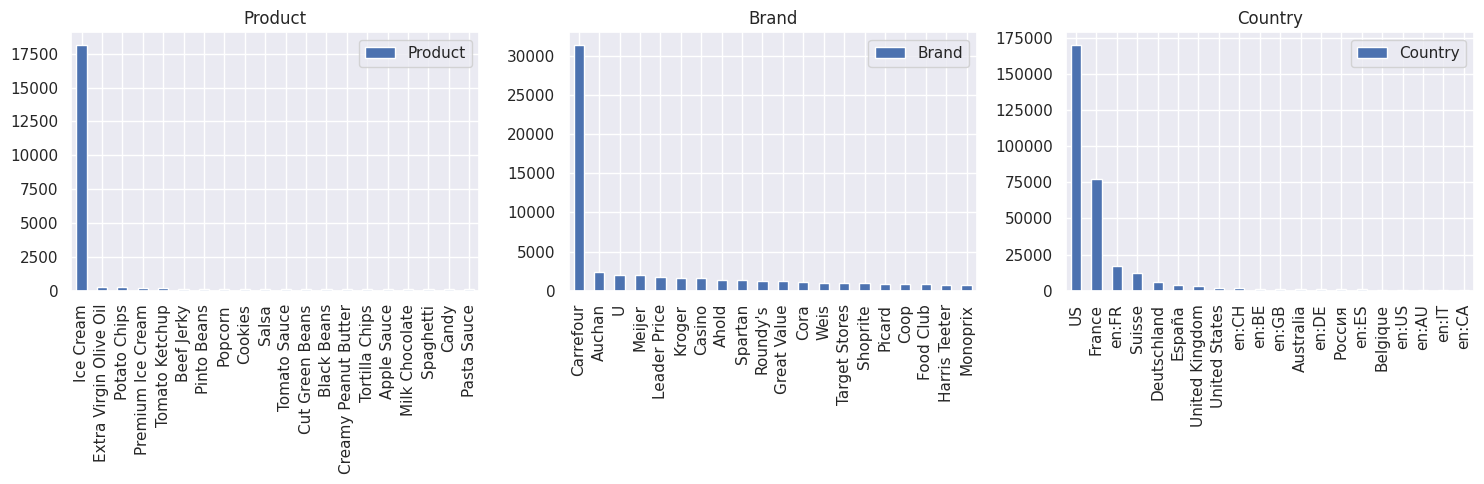

In [44]:
encoded_df = df.select_dtypes(include='object')#.apply(LabelEncoder().fit_transform)

object_cols = encoded_df.columns.to_list()

# Calculate number of rows needed for subplots
n = len(object_cols)
n_rows = n//3 if n%4 == 0 else n//3 + 1

fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows*5))

for ax, col in zip(axes.flatten(), object_cols):
    encoded_df[col].value_counts().to_frame().iloc[0:20].plot(kind='bar', ax=ax)
    ax.set_title(col)

# Remove empty subplots
if n % 4:
    for i in range(n, n_rows*4):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

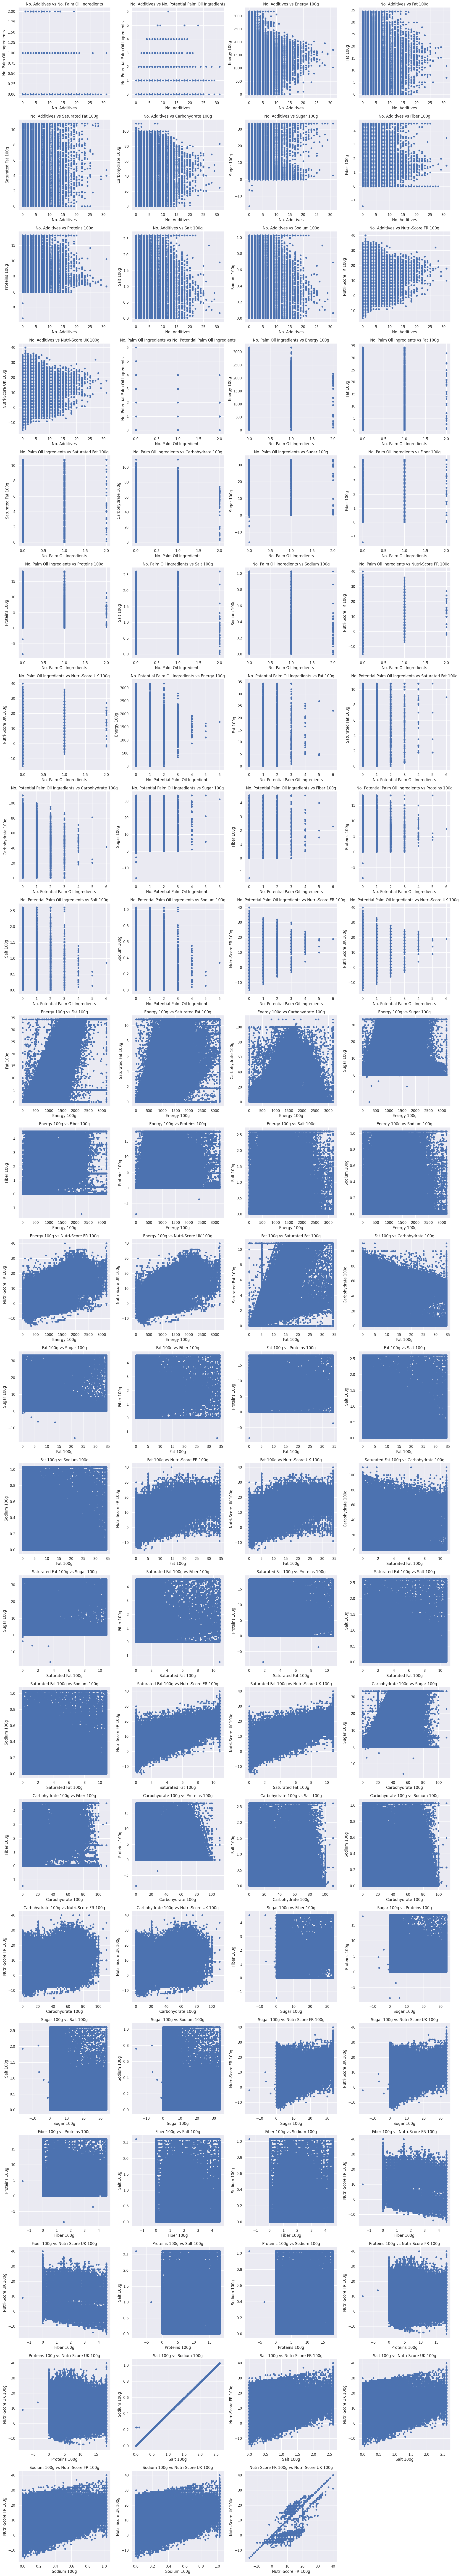

In [45]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate number of rows needed for subplots
n = len(numeric_cols)
n_rows = n*(n-1)//2  # Number of unique pairs
n_cols = 4  # Number of plots per row

# Prepare the subplot grid
n_full_rows = n_rows//n_cols
n_extra_plots = n_rows%n_cols
fig, axes = plt.subplots(n_full_rows + (1 if n_extra_plots else 0), n_cols, figsize=(20, 5*n_rows//n_cols))

# Flatten axes for easy iteration
axes = axes.flatten()

# Iterate over pairs of columns and create scatter plots
i = 0
for col1_idx in range(n):
    for col2_idx in range(col1_idx + 1, n):
        ax = axes[i]
        df.plot(kind='scatter', x=numeric_cols[col1_idx], y=numeric_cols[col2_idx], ax=ax)
        ax.set_title(f'{numeric_cols[col1_idx]} vs {numeric_cols[col2_idx]}')
        i += 1

# Remove empty subplots
for j in range(i, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

/tmp/ipykernel_1450/2885793406.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_heatmap = sns.heatmap(df.corr())


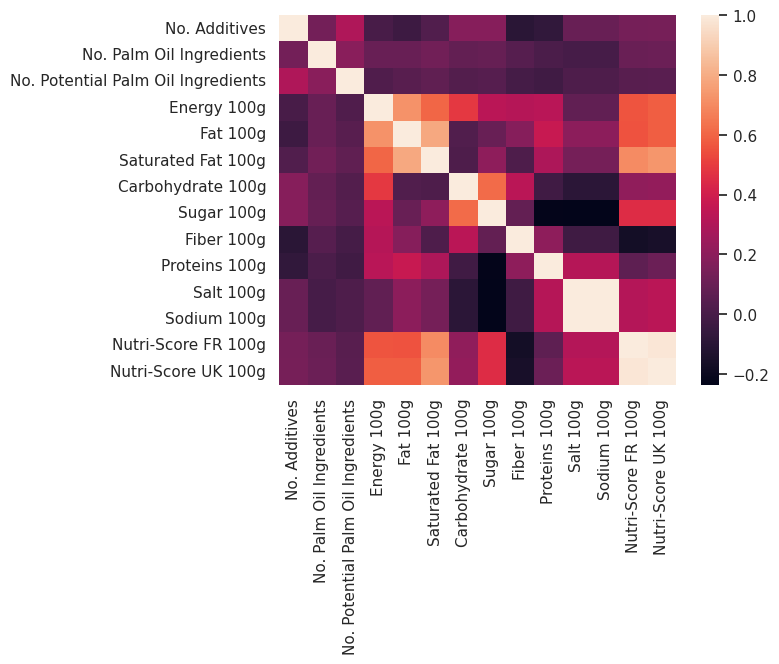

In [46]:
correlation_heatmap = sns.heatmap(df.corr())

# Notes 

- quantative ~ quantative
- quantative ~ qualataive
    - eta_squared, linear regression
- qualtative ~ qualitataive


PCA
- Statistics
- Visualisations

Explained variance ratio: [0.30567636 0.17140758 0.11972867 0.1016571  0.08806588 0.06054778]


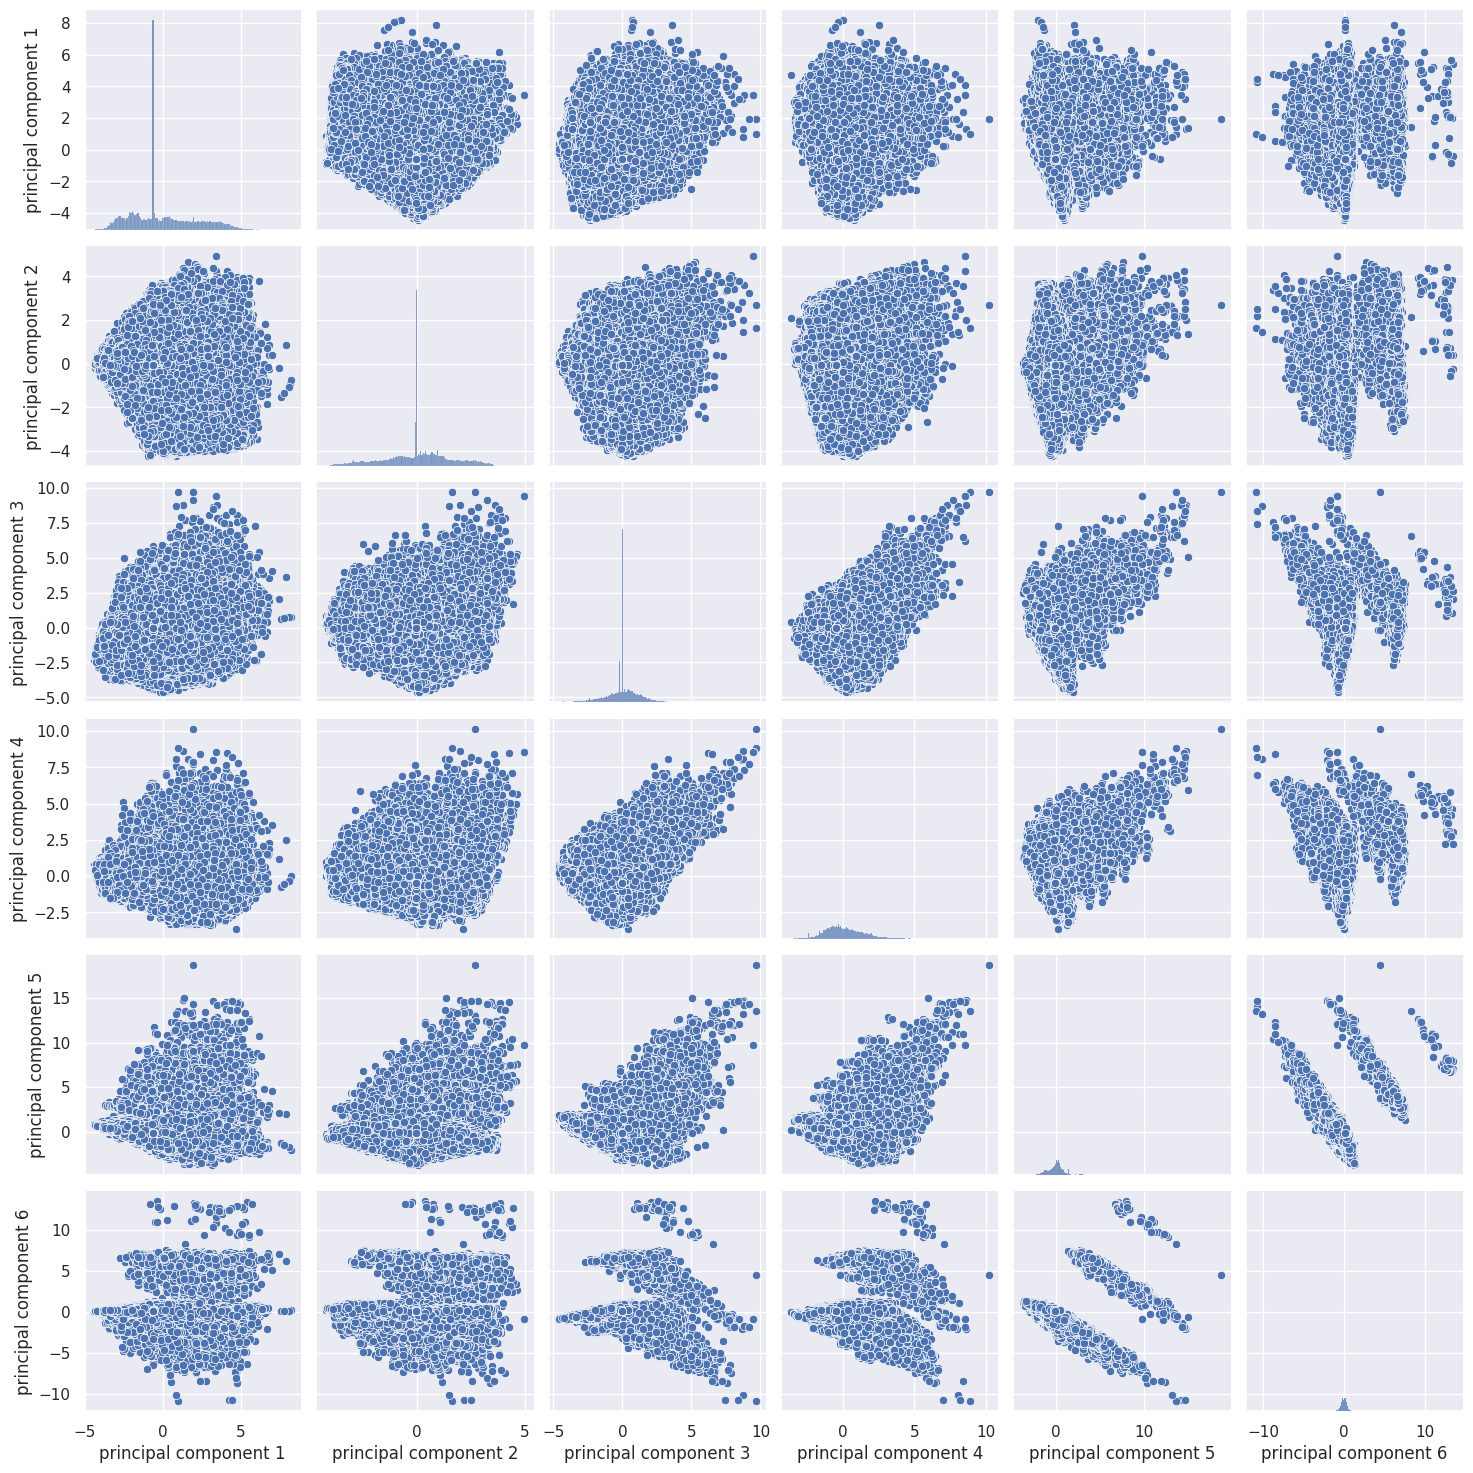

In [47]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming that df is your DataFrame and that it only contains numeric columns. If it has non-numeric columns, you should exclude them from this process.
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# 1. Standardize the data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df[numeric_cols])

# 2. Apply PCA
# 2. Apply PCA
pca = PCA(n_components=6)
principalComponents = pca.fit_transform(scaled_df)

# 3. Convert the results back to a dataframe
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6'])
# Print the explained variance ratio
print('Explained variance ratio:', pca.explained_variance_ratio_)

sns.pairplot(principalDf)

In [14]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LinearRegression

X = df[numeric_cols].iloc[:,:-2]
Y = df[numeric_cols].iloc[:,-1]


model = LinearRegression()
selector = RFE(model, step=1)

selector = selector.fit(X, Y)

X_transformed = selector.transform(X)

model.fit(X_transformed, Y)


LinearRegression()

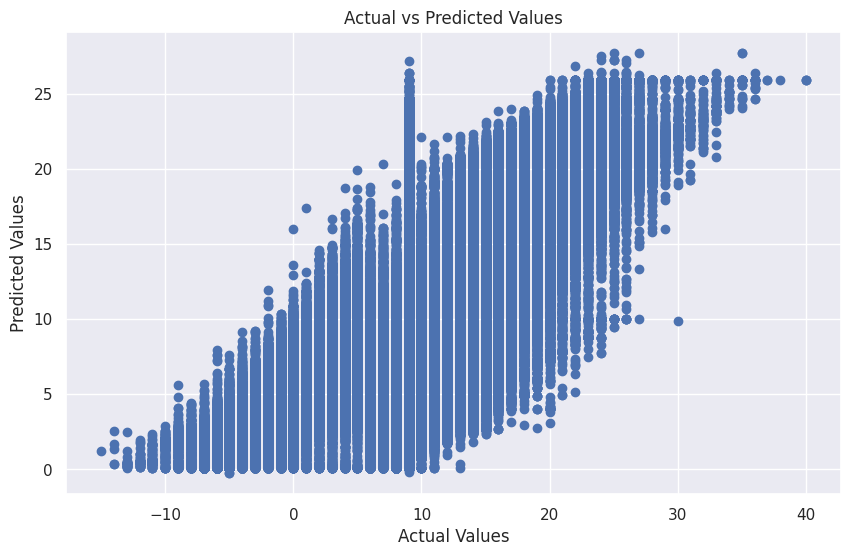

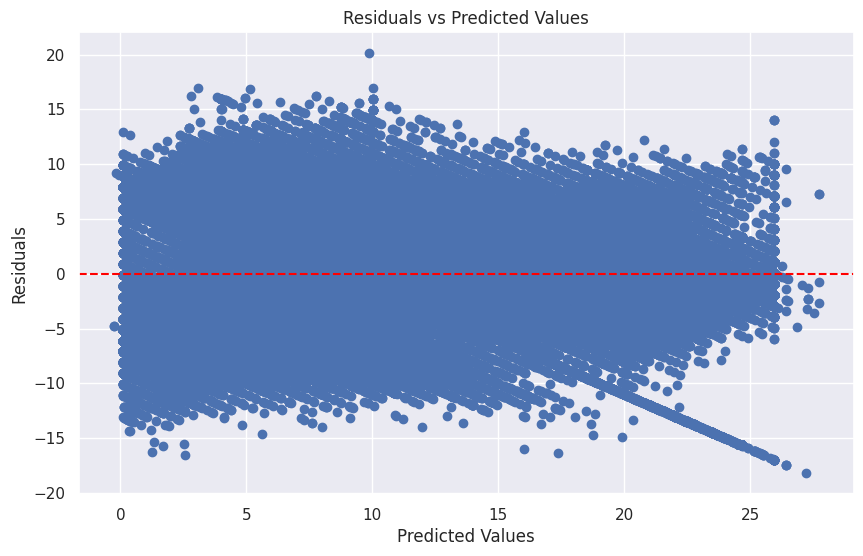

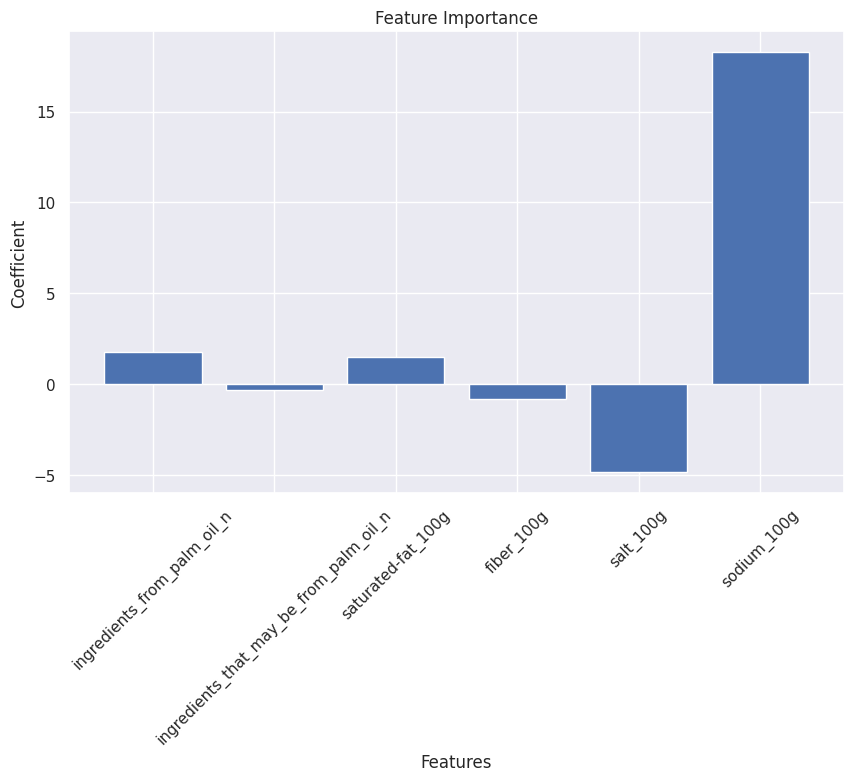

In [15]:
y_pred = model.predict(X_transformed)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(Y, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

residuals = Y - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()


selected_features = X.columns[selector.support_]
feature_importance = model.coef_

plt.figure(figsize=(10, 6))
plt.bar(selected_features, feature_importance)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()


In [16]:
X[X.columns[selector.support_].to_list()]

ingredients_from_palm_oil_n  ingredients_that_may_be_from_palm_oil_n  \
0                               0.0                                      0.0   
1                               0.0                                      0.0   
2                               0.0                                      0.0   
3                               0.0                                      0.0   
4                               0.0                                      0.0   
...                             ...                                      ...   
320767                          0.0                                      0.0   
320768                          0.0                                      0.0   
320769                          0.0                                      0.0   
320770                          0.0                                      0.0   
320771                          0.0                                      0.0   

        saturated-fat_100g  fiber_100g  salt_100g  sodium_100g  
0                     1.79        1.50    0.58166        0.229  
1                    10.80        3.60    0.00000        0.000  
2                     0.00        4.55    0.63500        0.250  
3                     5.36        4.55    1.22428        0.482  
4                     1.79        4.55    0.58166        0.229  
...                    ...         ...        ...          ...  
320767                1.79        1.50    0.58166        0.229  
320768                0.00        0.00    0.00000        0.000  
320769                1.79        1.50    0.58166        0.229  
320770                1.79        1.50    0.58166        0.229  
320771                1.79        1.50    0.00000        0.000  

[320772 rows x 6 columns]

In [18]:
import statsmodels.api as sm

X = X[X.columns[selector.support_].to_list()]
X_with_constant = sm.add_constant(X)
model = sm.OLS(df[numeric_cols[-1]], X_with_constant).fit()

print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     nutrition-score-uk_100g   R-squared:                       0.927
Model:                                 OLS   Adj. R-squared:                  0.927
Method:                      Least Squares   F-statistic:                 2.529e+05
Date:                     Thu, 03 Aug 2023   Prob (F-statistic):               0.00
Time:                             20:41:31   Log-Likelihood:            -6.8806e+05
No. Observations:                   320772   AIC:                         1.376e+06
Df Residuals:                       320755   BIC:                         1.376e+06
Df Model:                               16                                         
Covariance Type:                 nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [56]:
import statsmodels.api as sm

X = df[numeric_cols[:-2]]
X_with_constant = sm.add_constant(X)
model = sm.OLS(df[numeric_cols[-2]], X_with_constant).fit()

print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     Nutri-Score FR 100g   R-squared:                       0.776
Model:                             OLS   Adj. R-squared:                  0.776
Method:                  Least Squares   F-statistic:                 9.250e+04
Date:                 Mon, 07 Aug 2023   Prob (F-statistic):               0.00
Time:                         14:56:23   Log-Likelihood:            -8.6295e+05
No. Observations:               320772   AIC:                         1.726e+06
Df Residuals:                   320759   BIC:                         1.726e+06
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

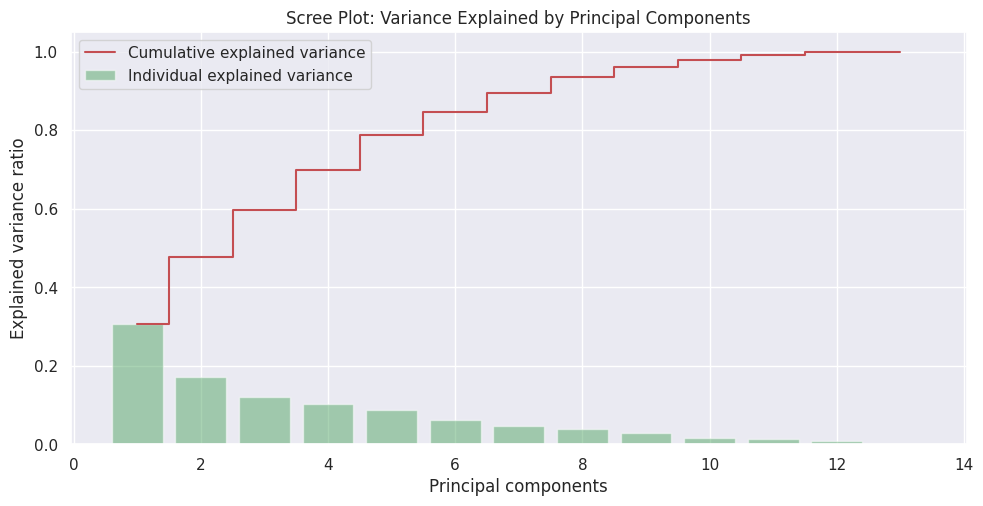

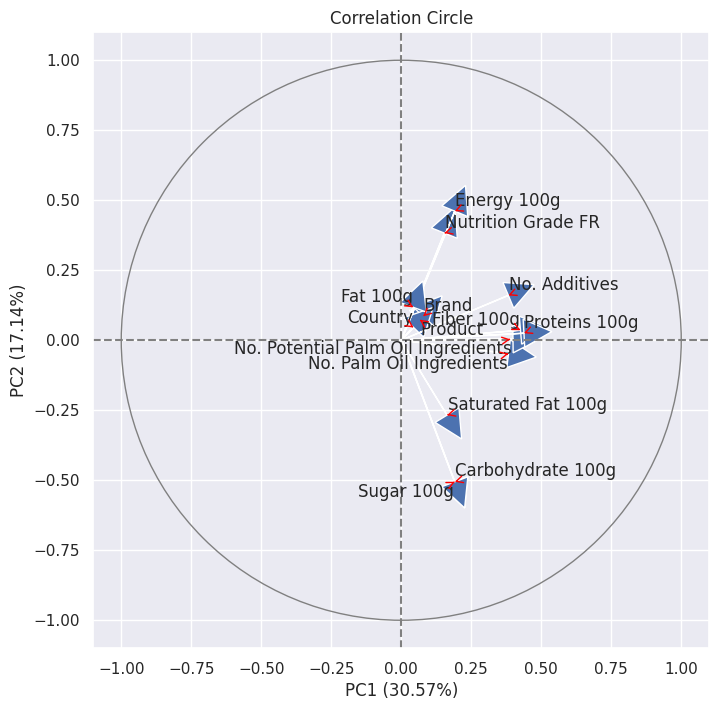

In [72]:
from adjustText import adjust_text
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


def plot_correlation_circle(df, dimension='2d'):

    df_copy = df.copy()
    columns = df_copy.select_dtypes(include=np.number).columns.to_list() #.apply(LabelEncoder().fit_transform)

    scaler = StandardScaler()
    df_std = scaler.fit_transform(df_copy[columns])

    pca = PCA(n_components="mle")
    pca_result = pca.fit_transform(df_std)

    # After fitting the PCA model
    plot_variance_explained(pca)

    if dimension == '2d':
        fig, ax = plt.subplots(figsize=(8, 8))

        pcs = pca.components_

        texts = []  # Collecting text objects for adjustment
        for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
            plt.arrow(0, 0, x, y, head_width=0.1, head_length=0.1)
            texts.append(plt.text(x, y, df.columns[i]))

        # Circle
        circle = plt.Circle((0, 0), 1, color='gray', fill=False)
        ax.add_artist(circle)

        # Adjust texts
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

        plt.xlim(-1.1, 1.1)  # Adjusting the limits to fit the circle
        plt.ylim(-1.1, 1.1)  # Adjusting the limits to fit the circle
        plt.axvline(0, color='grey', linestyle='--')
        plt.axhline(0, color='grey', linestyle='--')
        plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%})")
        plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%})")
        plt.title("Correlation Circle")
        plt.grid(True)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

    elif dimension == '3d':
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        pcs = pca.components_

        for i, (x, y, z) in enumerate(zip(pcs[0, :], pcs[1, :], pcs[2, :])):
            ax.quiver(0, 0, 0, x, y, z, arrow_length_ratio=0.1, color="black")
            ax.text(x, y, z, df_copy.columns[i], fontsize=10)

        # Set limits
        ax.set_xlim([-1.1, 1.1])
        ax.set_ylim([-1.1, 1.1])
        ax.set_zlim([-1.1, 1.1])

        # Create a sphere
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = np.outer(np.cos(u), np.sin(v))
        y = np.outer(np.sin(u), np.sin(v))
        z = np.outer(np.ones(np.size(u)), np.cos(v))

        ax.plot_wireframe(x, y, z, color="gray", alpha=0.1)

        ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%})")
        ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%})")
        ax.set_zlabel(f"PC3 ({pca.explained_variance_ratio_[2]:.2%})")
        ax.set_title("Correlation Sphere")
        plt.show()

    else:
        raise ValueError("Only '2d' and '3d' are valid dimensions.")

def plot_variance_explained(pca):
    explained_var = pca.explained_variance_ratio_
    cum_explained_var = np.cumsum(explained_var)
    
    plt.figure(figsize=(10, 5))
    
    # Bar plot for explained variance by each component
    plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.5, align='center',
            label='Individual explained variance', color='g')
    
    # Line plot for cumulative explained variance
    plt.step(range(1, len(explained_var) + 1), cum_explained_var, where='mid',
             label='Cumulative explained variance', color='r')
    
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.title('Scree Plot: Variance Explained by Principal Components')
    plt.grid(True)
    plt.show()



# Example usage
# Use this function after fitting the PCA model and standardizing the data
plot_correlation_circle(df, dimension='2d')

In [ ]:
import pandas as pd
from scipy.stats import f_oneway

# Sample DataFrame with multiple numerical columns and a categorical column
df = pd.DataFrame({
    'numerical1': [10, 20, 30, 40, 50, 60, 70, 30, 40],
    'numerical2': [5, 15, 25, 35, 45, 55, 65, 75, 85],
    'group': ['A', 'A', 'A', 'B', 'B', 'B', 'C', 'C', 'C']
})

# Select only numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Loop through the numerical columns and apply ANOVA for each one
for col in numerical_cols:
    groups = [df[col][df['group'] == g] for g in df['group'].unique()]
    f_statistic, p_value = f_oneway(*groups)

    # Print the results
    print(f"For {col}:")
    print(f"  F-statistic: {f_statistic}")
    print(f"  P-value: {p_value}")
    print()
